In [24]:
import pandas as pd
import numpy as np
import json
import seaborn as sns


In [25]:
with open('primed_qtable.json', 'r') as file:
    data = json.load(file)

In [26]:
data_df = pd.DataFrame(data)
data_df

,0,1,2,3,4,5,6
0,0.847324,0.681876,0.462306,0.371075,0.555337,0.226619,0.264459
1,0.745176,0.020496,0.462585,0.987732,0.422953,0.396351,0.856822
2,0.930677,0.497152,0.141753,0.476395,0.743549,0.775704,0.892396
3,0.349980,0.461254,0.644989,0.603580,0.275980,0.715152,0.608248
4,0.599636,0.464130,0.561719,0.823790,0.788660,0.677892,0.261316
...,...,...,...,...,...,...,...
5403,0.226838,0.290142,0.542891,0.512110,0.016249,0.253833,0.058184
5404,0.486790,0.764992,0.737800,0.383540,0.001065,0.291456,0.363490
5405,0.558444,0.831384,0.895799,0.956491,0.118831,0.943617,0.450316
5406,0.641746,0.495412,0.356875,0.345243,0.564069,0.135551,0.547984


In [27]:
import pickle
HEIGHT= 26
WIDTH = 26
def load_qtable(filename="qtable.pkl"):
    with open(filename, "rb") as f:
        qtable = pickle.load(f)
    return qtable

q_table = load_qtable()

In [28]:
q_table

,0,1,2,3,4,5,6
0,0.847324,0.681876,0.462306,0.371075,0.555337,0.226619,0.264459
1,0.745176,0.020496,0.462585,0.987732,0.422953,0.396351,0.856822
2,0.930677,0.497152,0.141753,0.476395,0.743549,0.775704,0.892396
3,0.349980,0.461254,0.644989,0.603580,0.275980,0.715152,0.608248
4,0.599636,0.464130,0.561719,0.823790,0.788660,0.677892,0.261316
...,...,...,...,...,...,...,...
5403,0.226838,0.290142,0.542891,0.512110,0.016249,0.253833,0.058184
5404,0.486790,0.764992,0.737800,0.383540,0.001065,0.291456,0.363490
5405,0.558444,0.831384,0.895799,0.956491,0.118831,0.943617,0.450316
5406,0.641746,0.495412,0.356875,0.345243,0.564069,0.135551,0.547984


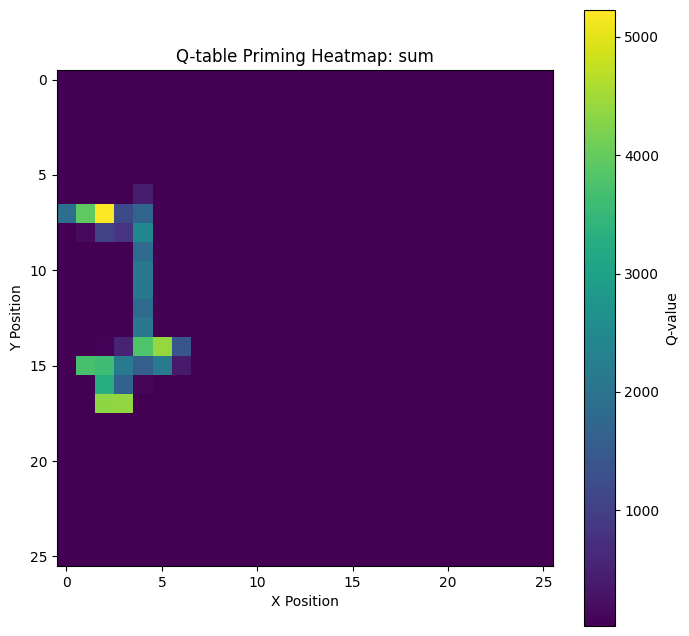

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qtable_heatmap(qtable, mode="sum"):
    collapsed = np.zeros((HEIGHT, WIDTH))

    #encoding: ((((x,y)*2 + cart)*2 + items)*2 + checkout)

    for x in range(HEIGHT):
        for y in range(WIDTH):
            cell_value = 0
            # binary has_cart
            for cart in [0, 1]:
                # binary has_items
                for items in [0, 1]:
                    # binary has_checkour
                    for checkout in [0, 1]:
                        idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)

                        if mode == "sum":
                            cell_value += qtable.loc[idx].sum() #sum of actions
                        elif mode == "max":
                            cell_value += qtable.loc[idx].max() #max of actions
                        else:
                            raise ValueError("mode wrong")

            collapsed[x, y] = cell_value

    plt.figure(figsize=(8, 8))
    plt.imshow(collapsed.T, origin="lower", aspect="equal")
    plt.colorbar(label="Q-value")
    
    ax = plt.gca()
    ax.invert_yaxis()

    plt.title(f"Q-table Priming Heatmap: {mode}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

plot_qtable_heatmap(qtable=q_table, mode="sum")


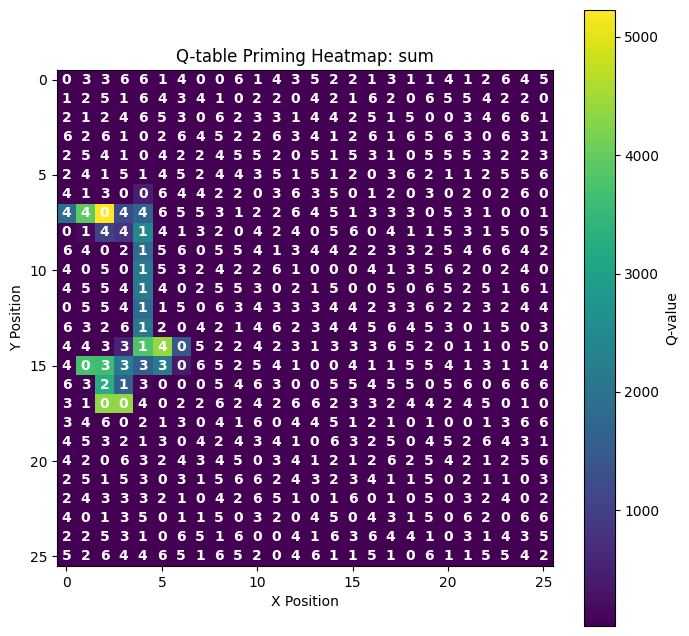

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qtable_heatmap(qtable, mode="sum"):
    collapsed = np.zeros((HEIGHT, WIDTH))
    best_actions = np.zeros((HEIGHT, WIDTH), dtype=int)

    for x in range(HEIGHT):
        for y in range(WIDTH):

            # collect q-values for each action across the 8 binary states
            all_qs = []

            for cart in [0, 1]:
                for items in [0, 1]:
                    for checkout in [0, 1]:
                        idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)

                        qvals = qtable.loc[idx].values
                        all_qs.append(qvals)

                        if mode == "sum": #sum of actions
                            collapsed[x, y] += qvals.sum()
                        elif mode == "max": #max of actions
                            collapsed[x, y] += qvals.max()
                        else:
                            raise ValueError("mode wrong")

            # average q values
            avg_q = np.mean(all_qs, axis=0)

            # best action index for this cell
            best_actions[x, y] = int(np.argmax(avg_q))

    plt.figure(figsize=(8, 8))
    plt.imshow(collapsed.T, origin="lower", aspect="equal")
    plt.colorbar(label="Q-value")

    ax = plt.gca()
    ax.invert_yaxis()

    # put action numbers in the heatmap
    for x in range(HEIGHT):
        for y in range(WIDTH):
            plt.text(x, y, str(best_actions[x, y]),ha='center', va='center',color='white', fontsize=10, fontweight='bold')

    plt.title(f"Q-table Priming Heatmap: {mode}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

plot_qtable_heatmap(qtable=q_table, mode="sum")


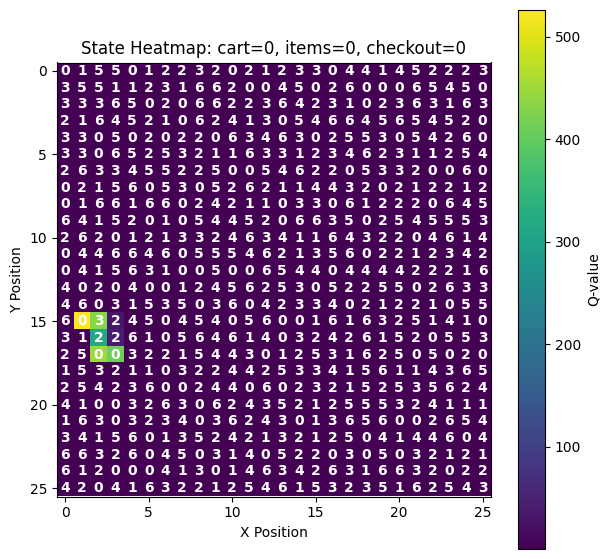

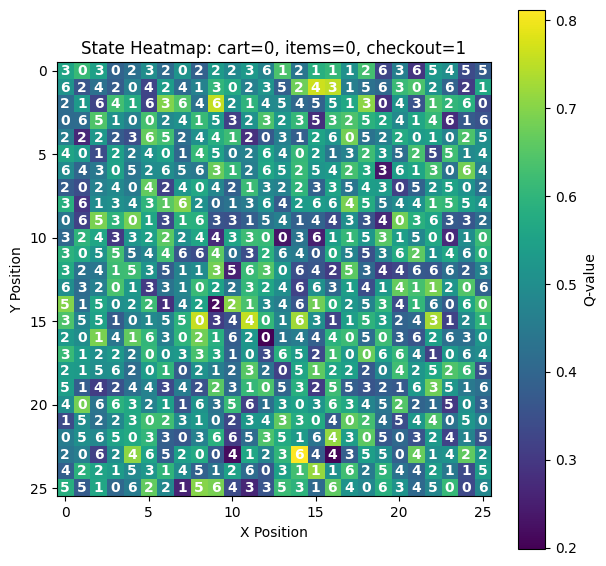

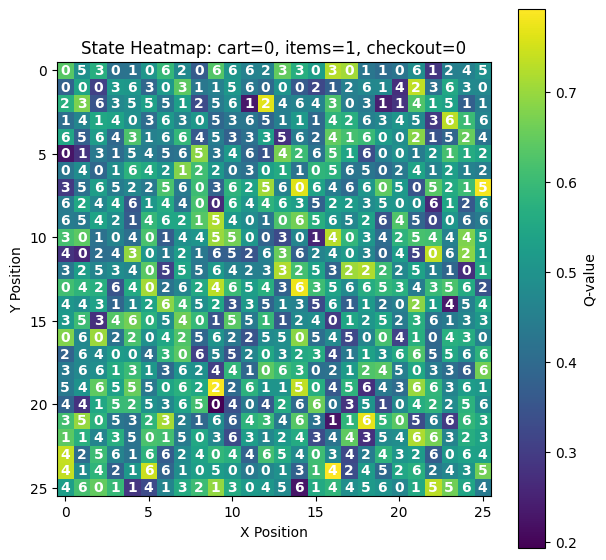

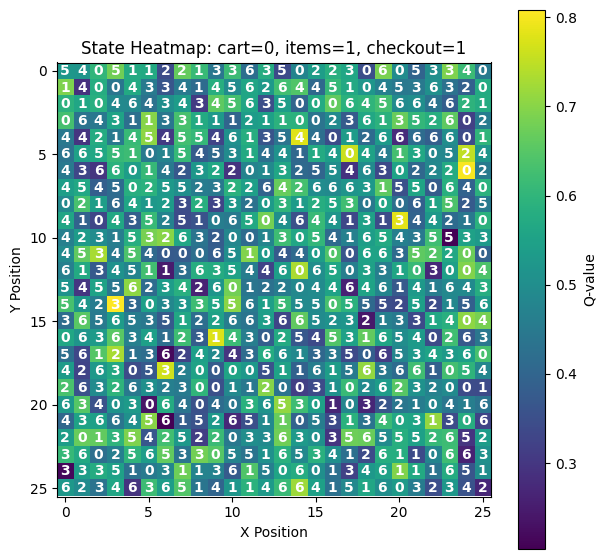

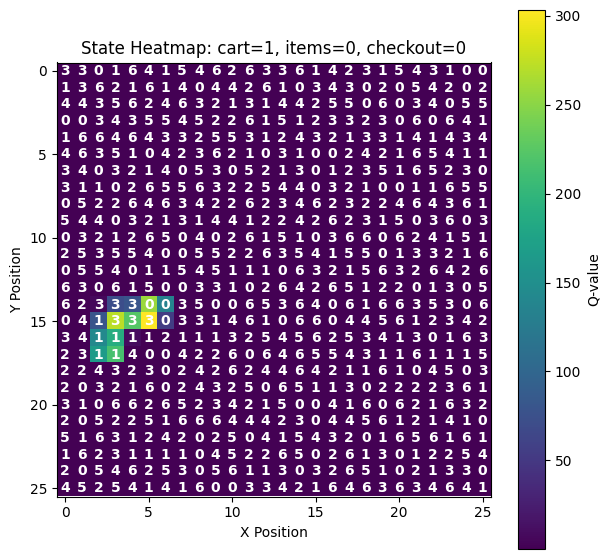

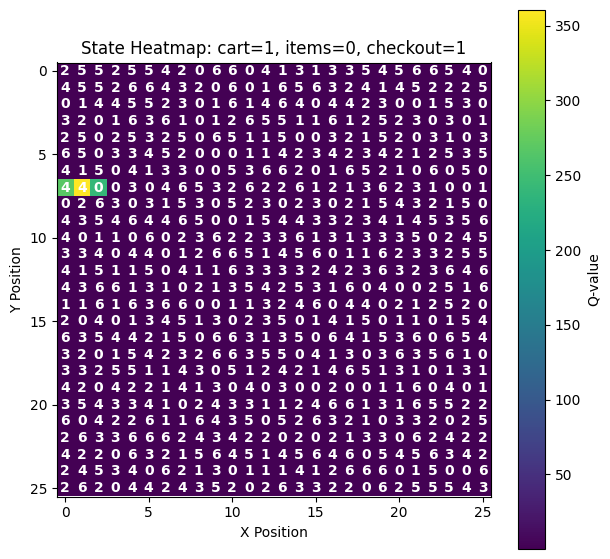

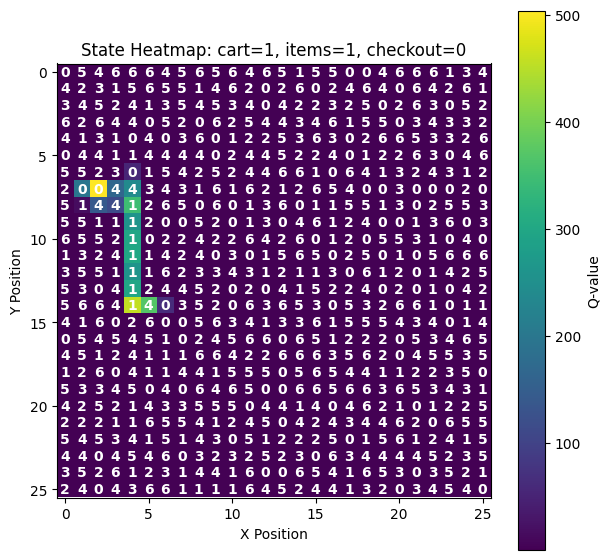

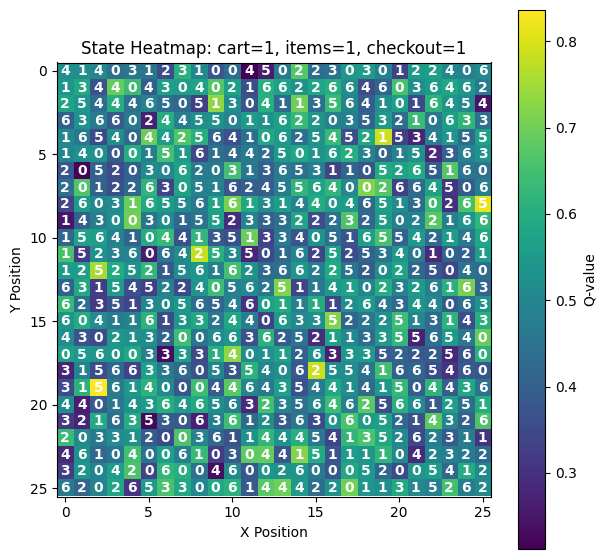

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_qtable_statewise(qtable):
    binary_states = list(itertools.product([0,1], repeat=3))  # (cart, items, checkout)

    for cart, items, checkout in binary_states:

        heatmap = np.zeros((HEIGHT, WIDTH))
        best_actions = np.zeros((HEIGHT, WIDTH), dtype=int)

        for x in range(HEIGHT):
            for y in range(WIDTH):

                # compute index into qtable
                idx = ((((x*HEIGHT + y)*2 + cart)*2 + items)*2 + checkout)

                qvals = qtable.loc[idx].values

                # Heatmap value → you can change to sum, mean, max, etc
                heatmap[x, y] = qvals.mean()

                # Best action at this state
                best_actions[x, y] = int(np.argmax(qvals))

        # ------------------ Plot ------------------
        plt.figure(figsize=(7, 7))
        plt.imshow(heatmap.T, origin="lower", aspect="equal")
        plt.colorbar(label="Q-value")

        ax = plt.gca()
        ax.invert_yaxis()

        # Overlay best-action numbers
        for x in range(HEIGHT):
            for y in range(WIDTH):
                plt.text(
                    x, y, str(best_actions[x, y]),
                    ha="center", va="center",
                    color="white", fontsize=10, fontweight="bold"
                )

        plt.title(f"State Heatmap: cart={cart}, items={items}, checkout={checkout}")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")

        plt.show()

plot_qtable_statewise(q_table)
